In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import names
from nltk.metrics.scores import precision, recall
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def team_features(team):
    info = {}
    for i in range(1,17):
        info[f"seed: {i}"] = False
        if int(team.SEED) == i:
          info[f"seed: {i}"] = True
    info["Win/Loss ratio"] = team.W / (team.G - team.W)
    info["2-point rate"] = team["2P_O"]
    info["3-point rate"] = team["3P_O"]
    
    return info

In [3]:
df = pd.read_csv("cbb.csv")
df = df.dropna()
df['SEED'] = df['SEED'].astype(str).str.replace('$', '',regex=True).astype('float')
df['3P_O'] = df['3P_O'].astype(str).str.replace('$', '',regex=True).astype('float')
df['2P_O'] = df['2P_O'].astype(str).str.replace('$', '',regex=True).astype('float')
df['W'] = df['W'].astype(str).str.replace('$', '',regex=True).astype('float')

In [4]:
data = []
for i in range(df.TEAM.size):
    curr = df.iloc[i]
    if curr.POSTSEASON != "NA" and curr.SEED != "NA":
      oneWin = "First round out" if curr.POSTSEASON in ["R68", "R64"] else "Past first round"  
      data.append((team_features(curr), oneWin))

In [5]:
def get_classifier(test_size, random_state):
    train_set, test_set = train_test_split(data, test_size=test_size, random_state=random_state)
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    return [train_set, test_set, classifier]

In [6]:
final_value  = [0 ,0 ,0, 0, 0]
for num in range(1, 10):
    test_size = num / 10.0
    for random_state in range(1, 50):
        train_set, test_set, classifier = get_classifier(test_size, random_state)
        y_true = list(list(zip(*test_set))[1])
        test_features = list(list(zip(*test_set))[0])
        y_predict = [classifier.classify(features) for features in test_features]
        (p,r,f,s) = precision_recall_fscore_support(y_true, y_predict)
        if (p[0] > final_value[0]):
            final_value[0] = p[0]
            final_value[1] = test_size
            final_value[2] = random_state
            final_value[3] = (p,r,f,s)
            final_value[4] = classifier

In [7]:
print("best precision_recall_fscore_support value with test size of " + str(final_value[1]) + " random state of " + str(final_value[2]) + " is " + str(final_value[3]) )

final_value[4].show_most_informative_features(15)

best precision_recall_fscore_support value with test size of 0.1 random state of 43 is (array([0.9047619 , 0.77777778]), array([0.76      , 0.91304348]), array([0.82608696, 0.84      ]), array([25, 23]))
Most Informative Features
                seed: 16 = True           First  : Past f =     21.6 : 1.0
                 seed: 2 = True           Past f : First  =     10.2 : 1.0
                seed: 15 = True           First  : Past f =      9.4 : 1.0
                 seed: 3 = True           Past f : First  =      9.3 : 1.0
                 seed: 4 = True           Past f : First  =      8.8 : 1.0
          Win/Loss ratio = 1.75           First  : Past f =      8.2 : 1.0
          Win/Loss ratio = 2.6            Past f : First  =      6.2 : 1.0
            3-point rate = 36.5           Past f : First  =      5.5 : 1.0
            2-point rate = 52.9           Past f : First  =      5.5 : 1.0
          Win/Loss ratio = 3.125          First  : Past f =      4.6 : 1.0
            2-point 

In [8]:
final_value1  = [0 ,0 ,0, 0]
for num in range(1, 10):
    test_size = num / 10.0
    for random_state in range(1, 50):
        train_set, test_set = train_test_split(data, test_size=0.2, random_state=36)

        # Modify the feature matrix to have 2D array shape
        X_train = [list(features.values()) for features, label in train_set]
        y_train = [label for features, label in train_set]
        X_test = [list(features.values()) for features, label in test_set]
        y_test = [label for features, label in test_set]

        clf = GaussianNB()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
        if (p[0] > final_value1[0]):
            final_value1[0] = p[0]
            final_value1[1] = test_size
            final_value1[2] = random_state
            final_value1[3] = (p,r,f,s)

In [9]:
print("best precision_recall_fscore_support value with test size of " + str(final_value1[1]) + " random state of " + str(final_value1[2]) + " is " + str(final_value1[3]) )

best precision_recall_fscore_support value with test size of 0.1 random state of 1 is (array([0.92592593, 0.57971014]), array([0.46296296, 0.95238095]), array([0.61728395, 0.72072072]), array([54, 42]))


In [10]:
df['win/loss'] = df.W / (df.G - df.W)
df1 = df[df['SEED'] == 16]
top_10 = df1.head(10)
top_10

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,win/loss
2047,UMBC,AE,33,25.0,102.1,102.2,0.4963,52.2,51.6,17.2,...,48.1,51.0,38.2,35.0,69.3,-4.9,R32,16.0,2018,3.125000
2175,Florida Gulf Coast,ASun,31,17.0,102.9,102.4,0.5136,51.5,47.7,17.2,...,51.5,48.3,34.2,31.2,68.0,-8.4,R64,16.0,2016,1.214286
2216,Coastal Carolina,BSth,30,20.0,104.5,103.0,0.5417,50.0,47.7,17.5,...,48.1,45.8,35.9,33.8,64.1,-5.1,R64,16.0,2015,2.000000
2219,Radford,BSth,34,23.0,101.3,102.8,0.4559,49.3,50.1,18.7,...,47.1,48.9,35.0,34.6,64.2,-6.5,R64,16.0,2018,2.090909
2220,Gardner Webb,BSth,32,23.0,106.0,106.6,0.4852,54.8,50.5,17.1,...,53.6,50.4,37.7,33.7,68.7,-5.0,R64,16.0,2019,2.555556
2222,UC Davis,BW,34,23.0,97.4,100.8,0.4033,48.4,48.7,20.3,...,46.9,48.5,34.5,32.6,70.3,-7.5,R64,16.0,2017,2.090909
2237,Penn,Ivy,32,24.0,103.6,97.6,0.6644,52.9,47.0,16.6,...,53.3,48.0,34.8,30.0,70.1,-3.3,R64,16.0,2018,3.000000
2242,Iona,MAAC,33,17.0,105.2,108.8,0.4044,53.0,52.3,17.3,...,53.2,50.3,35.1,36.6,71.9,-10.4,R64,16.0,2019,1.062500
2246,Hampton,MEAC,35,17.0,94.8,102.3,0.2939,45.6,46.4,20.2,...,45.6,44.5,30.4,33.9,69.6,-12.6,R64,16.0,2015,0.944444
2247,Hampton,MEAC,31,20.0,98.2,107.5,0.2615,46.7,48.6,18.7,...,47.3,47.5,30.5,33.8,71.9,-6.3,R64,16.0,2016,1.818182


<AxesSubplot:xlabel='TEAM', ylabel='win/loss'>

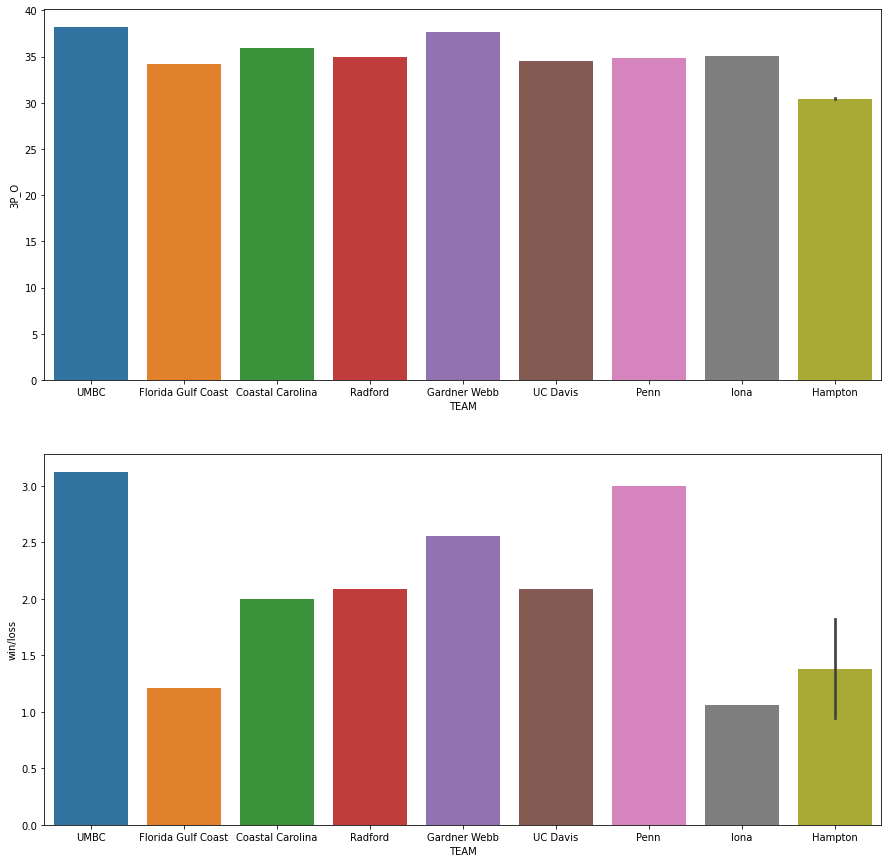

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))

ax = plt.subplot(2,1,1)
sns.barplot(data=top_10, x="TEAM", y="3P_O")

ax = plt.subplot(2,1,2)
sns.barplot(data=top_10, x="TEAM", y="win/loss")

<AxesSubplot:xlabel='YEAR', ylabel='W'>

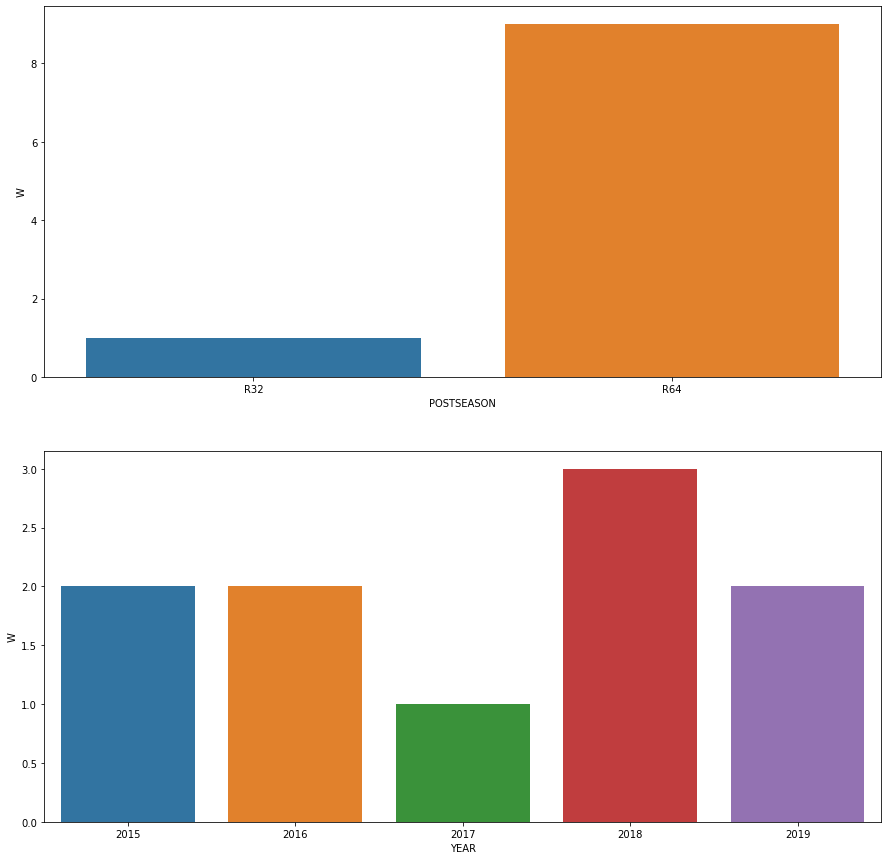

In [12]:
a = top_10.groupby('POSTSEASON').agg({'W':'count'}).reset_index()
b = top_10.groupby('YEAR').agg({'W':'count'}).reset_index()

fig, ax = plt.subplots(2, 1, figsize=(15,15))

ax = plt.subplot(2,1,1)
sns.barplot(data=a, x="POSTSEASON", y="W")

ax = plt.subplot(2,1,2)
sns.barplot(data=b, x="YEAR", y="W")

In [13]:
df2 = df[df['3P_O'] == 32.6]
top_10_2 = df2.head(10)
top_10_2

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,win/loss
2108,Alabama,SEC,36,20.0,107.9,95.3,0.8074,51.9,47.8,20.3,...,53.5,46.9,32.6,32.8,69.9,-1.1,R32,9.0,2018,1.250000
2249,Wyoming,MWC,33,23.0,102.1,98.2,0.6121,52.2,47.0,18.8,...,54.4,44.0,32.6,34.9,59.2,-1.6,R64,12.0,2015,2.300000
2271,Holy Cross,Pat,35,15.0,96.7,106.9,0.2398,47.9,53.2,16.8,...,47.2,52.8,32.6,35.7,64.6,-14.5,R64,16.0,2016,0.750000
2330,Western Michigan,MAC,32,22.0,104.7,102.5,0.5605,52.0,47.6,20.9,...,53.7,47.8,32.6,31.5,67.0,-2.9,R64,14.0,2014,2.200000
2337,Coastal Carolina,BSth,31,18.0,98.3,102.0,0.3946,48.0,47.5,20.2,...,47.6,46.7,32.6,32.4,67.5,-7.7,R64,16.0,2014,1.384615
2344,UNLV,MWC,34,24.0,104.7,88.4,0.8749,48.9,44.1,20.2,...,48.9,42.6,32.6,31.6,69.3,1.8,R64,5.0,2013,2.400000
2372,Tulsa,Amer,32,20.0,109.5,99.6,0.7486,50.3,48.2,15.6,...,51.1,45.0,32.6,35.9,69.4,-1.2,R68,11.0,2016,1.666667


<AxesSubplot:xlabel='YEAR', ylabel='W'>

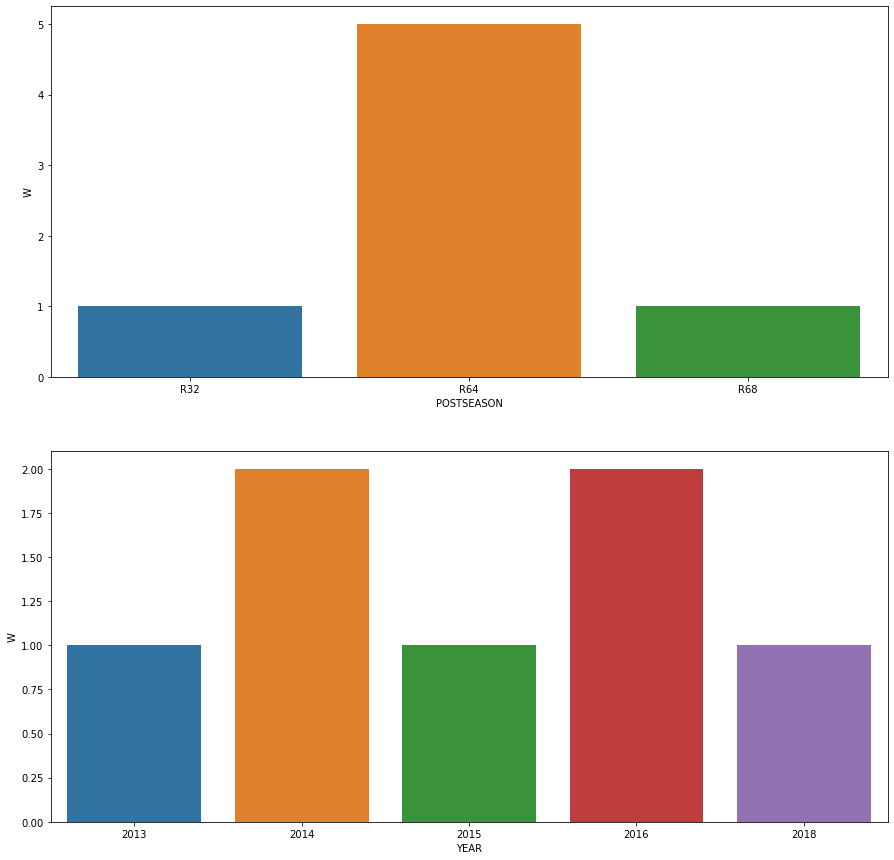

In [14]:
a1 = top_10_2.groupby('POSTSEASON').agg({'W':'count'}).reset_index()
b1 = top_10_2.groupby('YEAR').agg({'W':'count'}).reset_index()

fig, ax = plt.subplots(2, 1, figsize=(15,15))

ax = plt.subplot(2,1,1)
sns.barplot(data=a1, x="POSTSEASON", y="W")

ax = plt.subplot(2,1,2)
sns.barplot(data=b1, x="YEAR", y="W")